In [1]:
base_path = "/content/drive/MyDrive"

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress only FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Suppress only DeprecationWarnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Set options to control the display of DataFrames
pd.set_option('display.max_rows', 20)         # Number of rows to display
pd.set_option('display.max_columns', 50)       # Number of columns to display
pd.set_option('display.max_colwidth', 500)    # Maximum width of each column
pd.set_option('display.width', 10000)          # Width of the display in characters

In [ ]:
# Main Merge file : Prepared MIMIC III Data File for  further preprocessing
df_data = pd.read_csv(f"{base_path}/BM7/Dissertation/Final_Datasets/Final_Merged_Dataset_before_NLP.csv")

In [ ]:
df_data.shape

(46038, 8)

In [ ]:
df_data.head()

,SUBJECT_ID_diag,HADM_ID,GENDER,AGE_AT_ADMISSION,ICD9_CODE_diag,ICD9_CODE_proc,TEXT,DIAGNOSIS
0,109,172335,0,24,40301,5498,"Admission Date: [**2141-9-18**] Discharge Date: [**2141-9-24**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nhip pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\n\nHistory of Present Illness:\n24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] ...",LEG PAIN
1,109,173633,0,24,40301,3995,Admission Date: [**2141-12-8**] Discharge Date: [**2141-12-14**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 8104**]\nChief Complaint:\nabdominal pain & hypertension\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nPICC Line [**12-11**]\n\nHistory of Present Illness:\nMs [**Known lastname **] is a 24 year old woman with a history of CKD V (on HD)\nfrom lupus nephritis...,ABDOMINAL PAIN
2,112,174105,1,300,53100,4443,"Admission Date: [**2194-6-13**] Discharge Date: [**2194-6-18**]\n\n\nService:\n\n\nHISTORY OF PRESENT ILLNESS: The patient is a [**Age over 90 **]-year-old man\nwith a history of peptic ulcer disease, coronary artery\ndisease, status post myocardial infarction in [**2179**] as well as\n[**2193**], temporal arteritis, who presented with melenas and\nchest pain. The patient reported melanotic stools times 5\nsince 4 p.m. on the day prior to admission. No hematemesis or\nhematochezia. ...",GASTROINTESTINAL BLEED
3,113,109976,1,35,1915,159,"Admission Date: [**2140-12-12**] Discharge Date: [**2140-12-27**]\n\nDate of Birth: [**2105-2-9**] Sex: M\n\nService:\n\n\nHISTORY OF PRESENT ILLNESS: The patient is a 35 year old\ngentleman who woke up with severe headache, woke up with a\n[**11-20**] frontal headache that was constant. Took Advil and\nTylenol without relief. Headache persisted. He went to an\noutside hospital, where an MRI of the brain showed\nhydrocephalus and a cystic mass around the pineal gland. Th...",HYDROCEPHALUS
4,114,178393,1,48,41401,3612,Admission Date: [**2146-8-29**] Discharge Date: [**2146-9-3**]\n\nDate of Birth: [**2098-5-9**] Sex: M\n\nService: Cardiothoracic Surgery\n\nADMITTING DIAGNOSIS: Coronary artery disease requiring\nrevascularization.\n\nHISTORY OF PRESENT ILLNESS: This is a 48-year-old man in\ngenerally good health with a new onset of dyspnea on exertion\nand angina who underwent a cardiac catheterization on [**8-29**]\nwhich revealed two vessel coronary artery disease with an\nejection fr...,USA/SDA


# **Feature Engineering**


## Extracting Relevant subheadings from Unstructured Discharge Summary

In [ ]:
df_data['TEXT'][1]

"Admission Date:  [**2141-12-8**]              Discharge Date:   [**2141-12-14**]\n\nDate of Birth:  [**2117-8-7**]             Sex:   F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 8104**]\nChief Complaint:\nabdominal pain & hypertension\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nPICC Line [**12-11**]\n\nHistory of Present Illness:\nMs [**Known lastname **] is a 24 year old woman with a history of CKD V (on HD)\nfrom lupus nephritis, chronic intermittent abdominal pain, and\nmultiple prior ICU admissions for hypertensive urgency who\npresented to the ED complaining of two days' of abdominal pain,\nnausea, and loose stools. She was feeling well until after her\nhemodialysis session on Wednesday. Thereafter, she complained of\nnausea with occasional vomitting and has been unable to keep\ndown any of her oral medications. She also has had diffuse\nabdominal pain consistent with her prior flares of pain as well\nas her typical di

In [ ]:
subheading_variants = {
    'Chief Complaint': ['Chief Complaint'],
    'History of Present Illness': ['History of Present Illness'],
    'Past Medical History': ['Past Medical History'],
    'Discharge Diagnoses': ['Discharge Diagnoses', 'Discharge Diagnosis'],
    'Discharge Medications': ['Discharge Medications']
}


In [ ]:
import pandas as pd
import numpy as np
import re

def extract_and_populate(df, subheading_variants):
    # Create a case-insensitive regex pattern for subheading variants
    pattern = '|'.join([
        fr"(?i)({'|'.join(re.escape(variant) for variant in variants)}):"
        for variants in subheading_variants.values()
    ])

    # Initialize new columns in the DataFrame
    for key in subheading_variants.keys():
        df[key] = np.NaN

    for index, row in df.iterrows():
        text = row['TEXT']

        # Find all subheading matches (case-insensitive)
        matches = list(re.finditer(pattern, text))
        last_match_end = 0
        last_subheading = None

        # Process each section between subheadings
        for match in matches:
            subheading = match.group(0).rstrip(':').capitalize()  # Capitalize to standardize

            # Capture and assign the section content
            if last_subheading:
                section_content = text[last_match_end:match.start()].strip()
                if last_subheading == 'Discharge Diagnoses':
                    # Trim the section content after `\n\n\nDischarge`
                    section_content = re.split(r'\n\n\nDischarge', section_content, maxsplit=1)[0]
                df.at[index, last_subheading] = section_content

            last_match_end = match.end()
            last_subheading = next((
                key for key, values in subheading_variants.items()
                if subheading.lower() in map(str.lower, values)
            ), None)

        # Handle the last section after the final subheading
        if last_subheading:
            section_content = text[last_match_end:].strip()
            if last_subheading == 'Discharge Diagnoses':
                # Trim the section content after `\n\n\nDischarge`
                section_content = re.split(r'\n\n\nDischarge', section_content, maxsplit=1)[0]
            df.at[index, last_subheading] = section_content

        # Handle any text not captured by specific subheadings
        if last_subheading != 'Uncategorized':
            uncategorized_content = text[:last_match_end].strip()
            if uncategorized_content:
                df.at[index, 'Uncategorized'] = uncategorized_content

    # Replace any remaining "nan" strings with actual NaN
    df.replace("nan", np.NaN, inplace=True)

    return df

# Apply the function to your DataFrame
df_data = extract_and_populate(df_data, subheading_variants)

# Now the 'Discharge Diagnoses' column should have trimmed content
df_data.head()


<ipython-input-23-ccf00add9a11>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'hip pain

Major Surgical or Invasive Procedure:
None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, last_subheading] = section_content
<ipython-input-23-ccf00add9a11>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24yo woman with hx SLE, CKD(not currently on HD or PD), labile
HTN here with right leg pain and HTN urgency. Patient was
recently d/ced on [**9-14**] following admission for the same
complaints.
.
Patient took her hydralazine dose on am of admission. BP at
presentation to the ER was 250/140 (The patient reportedly has
baseline SBPs in 130-170s) She was given 900 labetolol and 50
hydralazine in the ED. BP following this was 175/124. Her EKG
was unchanged. K was 5.7.
.
Patient also complaining of

,SUBJECT_ID_diag,HADM_ID,GENDER,AGE_AT_ADMISSION,ICD9_CODE_diag,ICD9_CODE_proc,TEXT,DIAGNOSIS,Chief Complaint,History of Present Illness,Past Medical History,Discharge Diagnoses,Discharge Medications,Uncategorized
0,109,172335,0,24,40301,5498,"Admission Date: [**2141-9-18**] Discharge Date: [**2141-9-24**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nhip pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\n\nHistory of Present Illness:\n24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] ...",LEG PAIN,hip pain\n\nMajor Surgical or Invasive Procedure:\nNone,"24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] following admission for the same\ncomplaints.\n.\nPatient took her hydralazine dose on am of admission. BP at\npresentation to the ER was 250/140 (The patient reportedly has\nbaseline SBPs in 130-170s) She was given 900 labetolol and 50\nhydralazine in the ED. BP following this was 175/124. Her EKG\nwas unchanged. K was 5.7.\n.\nPatient also ...","Systemic lupus erythematosus. Diagnosed [**2134**] (16 years old)\nwhen she had swollen fingers, arm rash and arthralgias. Previous\n\ntreatment with cytoxan, cellcept; currently on prednisone.\nComplicated by uveitis ([**2139**]) and ESRD ([**2135**]).\n- CKD/ESRD. Diagosed [**2135**]. Initiated dialysis [**2137**]. PD catheter\n\nplacement [**5-18**]. Pt reluctant to start PD.\n- Malignant hypertension. Baseline BPs 180's - 120's. History of\n\nhypertensive crisis with seizures. History of...",Primary:\nHypertensive urgency\nTransient Hypotension due to Narcotics\nSciatica\n.\nSecondary:\nEnd stage renal disease\nSystemic Lupus Erythematosus\nAnemia,"1. Prednisone 5 mg Tablet Sig: One (1) Tablet PO DAILY (Daily).\n\n2. Clonidine 0.3 mg/24 hr Patch Weekly Sig: One (1) Patch Weekly\nTransdermal QWED (every Wednesday).\n3. Calcium Carbonate 500 mg Tablet, Chewable Sig: One (1)\nTablet, Chewable PO QID (4 times a day).\n4. Lactulose 10 gram/15 mL Syrup Sig: Thirty (30) ML PO TID (3\ntimes a day).\n5. Labetalol 300 mg Tablet Sig: Three (3) Tablet PO three times\na day.\n6. Nifedipine 60 mg Tablet Sustained Release Sig: One (1) Tablet\nSustain...","Admission Date: [**2141-9-18**] Discharge Date: [**2141-9-24**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nhip pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\n\nHistory of Present Illness:\n24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] ..."
1,109,173633,0,24,40301,3995,Admission Date: [**2141-12-8**] Discharge Date: [**2141-12-14**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 8104**]\nChief Complaint:\nabdominal pain & hypertension\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nPICC Line [**12-11**]\n\nHistory of Present Illness:\nMs [**Known lastname **] is a 24 year old woman with a history of CKD V (on HD)\nfrom lupus nephritis...,ABDOMINAL PAIN,abdominal pain & hypertension\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\nPICC Line [**12-11**],"Ms [**Known lastname **] is a 24 year old woman with a history of CKD V (on HD)\nfrom lupus nephritis, chronic intermittent abdominal pain, and\nmultiple prior ICU admissions for hypertensive urgency who\npresented to the ED complaining of two days' of abdominal pain,\nnausea, and loose stools. She was feeling well until after her\nhemodialysis session on Wednesday. Thereafter, she complained of\nnausea with occasional vomitting and has been unable to keep\nd

In [ ]:
df_data['Discharge Diagnoses'].head()

,Discharge Diagnoses
0,Primary:\nHypertensive urgency\nTransient Hypotension due to Narcotics\nSciatica\n.\nSecondary:\nEnd stage renal disease\nSystemic Lupus Erythematosus\nAnemia
1,Primary:\nHypertensive Urgency\nAbdominal Pain\nESRD on HD\nSVC Thrombus\n\nSecondary:\nSystemic lupus erythematosus\nMalignant hypertension\nThrombocytopenia\nHOCM\nAnemia\nHistory of left eye enucleation\nHistory of vaginal bleeding\nThrombotic microangiopathy
2,"Gastric ulcer.\nGastrointestinal bleed.\nDemand ischemia, elevated troponins, and EKG changes in the\nsetting of acute blood loss anemia."
3,NaN
4,"1. Hypercholesterolemia.\n2. Coronary artery disease, status post CABG times three\nperformed on [**2146-8-29**].\n\n\n\n\n [**First Name11 (Name Pattern1) 275**] [**Last Name (NamePattern4) 1539**], M.D. [**MD Number(1) 1540**]\n\nDictated By:[**Name8 (MD) 4720**]\nMEDQUIST36\n\nD: [**2146-9-3**] 15:21\nT: [**2146-9-3**] 15:28\nJOB#: [**Job Number 35153**]"


In [ ]:
df_data.shape

(46038, 14)

# **Export Feature Engineering Dataset**

In [ ]:
df_data.to_csv(f"{base_path}/BM7/Dissertation/Final_Datasets/Final_Unstructured_Features_Before_NLP.csv", index=False)

In [ ]:
df_data.head(1)

,SUBJECT_ID_diag,HADM_ID,GENDER,AGE_AT_ADMISSION,ICD9_CODE_diag,ICD9_CODE_proc,TEXT,DIAGNOSIS,Chief Complaint,History of Present Illness,Past Medical History,Discharge Diagnoses,Discharge Medications,Uncategorized,Chief Complaint_length,History of Present Illness_length,Past Medical History_length,Discharge Diagnoses_length,Discharge Medications_length
0,109,172335,0,24,40301,5498,"Admission Date: [**2141-9-18**] Discharge Date: [**2141-9-24**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nhip pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\n\nHistory of Present Illness:\n24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] ...",LEG PAIN,hip pain\n\nMajor Surgical or Invasive Procedure:\nNone,"24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] following admission for the same\ncomplaints.\n.\nPatient took her hydralazine dose on am of admission. BP at\npresentation to the ER was 250/140 (The patient reportedly has\nbaseline SBPs in 130-170s) She was given 900 labetolol and 50\nhydralazine in the ED. BP following this was 175/124. Her EKG\nwas unchanged. K was 5.7.\n.\nPatient also ...","Systemic lupus erythematosus. Diagnosed [**2134**] (16 years old)\nwhen she had swollen fingers, arm rash and arthralgias. Previous\n\ntreatment with cytoxan, cellcept; currently on prednisone.\nComplicated by uveitis ([**2139**]) and ESRD ([**2135**]).\n- CKD/ESRD. Diagosed [**2135**]. Initiated dialysis [**2137**]. PD catheter\n\nplacement [**5-18**]. Pt reluctant to start PD.\n- Malignant hypertension. Baseline BPs 180's - 120's. History of\n\nhypertensive crisis with seizures. History of...",Primary:\nHypertensive urgency\nTransient Hypotension due to Narcotics\nSciatica\n.\nSecondary:\nEnd stage renal disease\nSystemic Lupus Erythematosus\nAnemia,"1. Prednisone 5 mg Tablet Sig: One (1) Tablet PO DAILY (Daily).\n\n2. Clonidine 0.3 mg/24 hr Patch Weekly Sig: One (1) Patch Weekly\nTransdermal QWED (every Wednesday).\n3. Calcium Carbonate 500 mg Tablet, Chewable Sig: One (1)\nTablet, Chewable PO QID (4 times a day).\n4. Lactulose 10 gram/15 mL Syrup Sig: Thirty (30) ML PO TID (3\ntimes a day).\n5. Labetalol 300 mg Tablet Sig: Three (3) Tablet PO three times\na day.\n6. Nifedipine 60 mg Tablet Sustained Release Sig: One (1) Tablet\nSustain...","Admission Date: [**2141-9-18**] Discharge Date: [**2141-9-24**]\n\nDate of Birth: [**2117-8-7**] Sex: F\n\nService: MEDICINE\n\nAllergies:\nPenicillins / Percocet\n\nAttending:[**First Name3 (LF) 1936**]\nChief Complaint:\nhip pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\n\nHistory of Present Illness:\n24yo woman with hx SLE, CKD(not currently on HD or PD), labile\nHTN here with right leg pain and HTN urgency. Patient was\nrecently d/ced on [**9-14**] ...",8,174,2029,19,193


In [ ]:
df_data.describe()

,SUBJECT_ID_diag,HADM_ID,GENDER,AGE_AT_ADMISSION,ICD9_CODE_proc,Chief Complaint_length,History of Present Illness_length,Past Medical History_length,Discharge Diagnoses_length,Discharge Medications_length
count,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000,46038.000000
mean,34490.008428,150036.201507,0.569312,67.621726,5050.834028,16.434836,216.417459,924.087732,37.376906,147.278509
std,28338.734291,28926.040691,0.495178,53.713826,3199.240915,40.047208,221.599449,665.965239,72.482722,128.306869
min,3.000000,100003.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12255.500000,124973.250000,0.000000,49.000000,3522.000000,2.000000,75.000000,497.000000,7.000000,4.000000
50%,24707.500000,150132.500000,1.000000,63.000000,3950.000000,11.000000,169.000000,836.000000,16.000000,142.000000
75%,55675.750000,175174.500000,1.000000,76.000000,8622.000000,19.000000,283.000000,1253.000000,39.000000,235.000000
max,99999.000000,199999.000000,1.000000,310.000000,9995.000000,2319.000000,3157.000000,7340.000000,2450.000000,1394.000000


# **EDA on Engineered Features**

In [ ]:
df_data = pd.read_csv(f"{base_path}/BM7/Dissertation/Final_Datasets/Final_Unstructured_Features_Before_NLP.csv")

In [ ]:
subheadings = ['Chief Complaint', 'History of Present Illness', 'Past Medical History', 'Discharge Diagnoses', 'Discharge Medications']

1. Word Cloud for Each Extracted Subheading

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

subheadings = ['Chief Complaint', 'History of Present Illness', 'Past Medical History', 'Discharge Diagnoses', 'Discharge Medications']

# Generate word clouds for each subheading
for subheading in subheadings:
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(background_color='white', max_words=100, colormap='viridis').generate(' '.join(df_data[subheading].dropna()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {subheading}')
    plt.show()


**Heatmap of Subheading Co-occurrences**: To identify patterns in which certain subheadings tend to be filled out together, which could indicate common reporting practices or related clinical conditions.

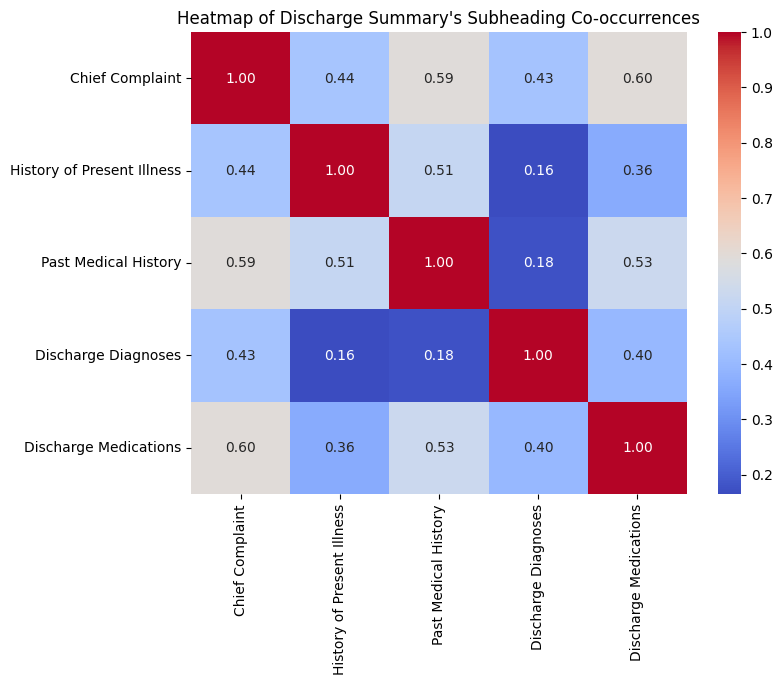

In [ ]:
import numpy as np

# Create a binary presence matrix for subheadings
subheading_presence = df_data[subheadings].notnull().astype(int)

# Calculate the correlation matrix
correlation_matrix = subheading_presence.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Discharge Summary\'s Subheading Co-occurrences')
plt.show()


## Distribution of Text Lengths

Objective:
To show that "Discharge Diagnosis" and "Chief Complaint" are concise and focused, often summarizing critical clinical information. This makes them ideal for phenotyping tasks.

Visualization:
A violin plot is used to visualize the distribution of text lengths for all subheadings, highlighting the spread and density of the data.

<ipython-input-27-dff6c84497a2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_length_melted, x='Subheading', y='Length', palette='Set2', inner='quartile')


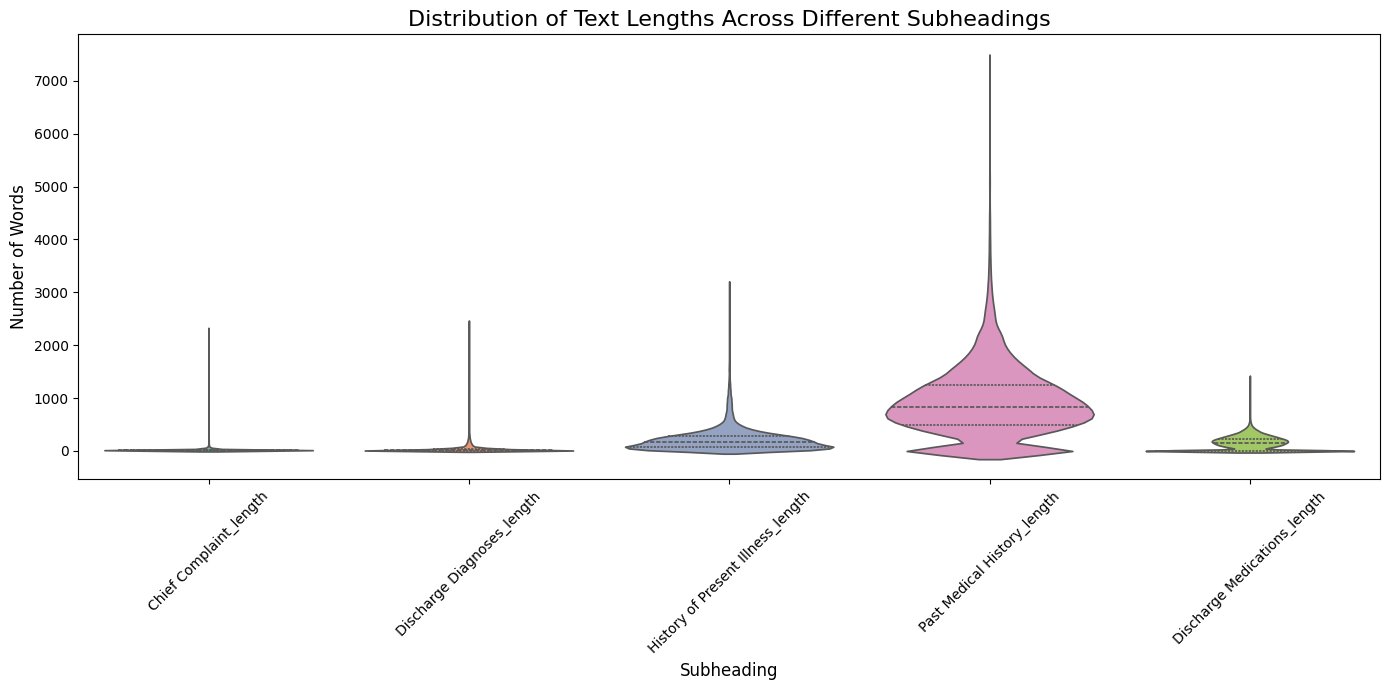

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for plotting
subheadings_to_plot = ['Chief Complaint_length', 'Discharge Diagnoses_length', 'History of Present Illness_length', 'Past Medical History_length', 'Discharge Medications_length']
df_length_melted = df_data[subheadings_to_plot].melt(var_name='Subheading', value_name='Length')

plt.figure(figsize=(14, 7))
sns.violinplot(data=df_length_melted, x='Subheading', y='Length', palette='Set2', inner='quartile')
plt.title('Distribution of Text Lengths Across Different Subheadings', fontsize=16)
plt.xlabel('Subheading', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


Highlight: "Chief Complaint" and "Discharge Diagnoses" have shorter, more focused text compared to other subheadings, indicating their specificity and relevance for capturing essential clinical information.

## Correlation with Structured Data


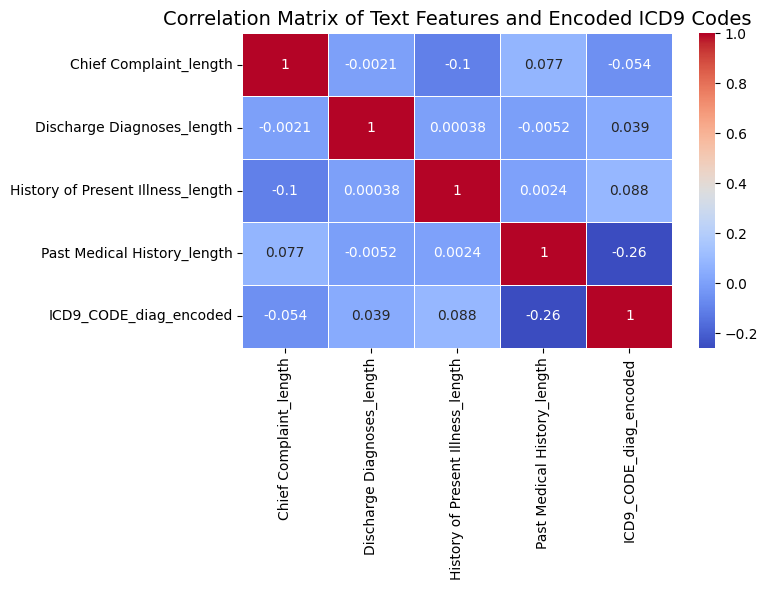

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Encode ICD codes
le = LabelEncoder()
df_data['ICD9_CODE_diag_encoded'] = le.fit_transform(df_data['ICD9_CODE_diag'])

# Convert text features to numerical representations (e.g., length of text)
df_data['Chief Complaint_length'] = df_data['Chief Complaint'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df_data['Discharge Diagnoses_length'] = df_data['Discharge Diagnoses'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df_data['History of Present Illness_length'] = df_data['History of Present Illness'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
df_data['Past Medical History_length'] = df_data['Past Medical History'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Create a dataframe with lengths and encoded ICD9 codes
correlation_data = df_data[['Chief Complaint_length', 'Discharge Diagnoses_length',
                            'History of Present Illness_length', 'Past Medical History_length',
                            'ICD9_CODE_diag_encoded']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Text Features and Encoded ICD9 Codes', fontsize=14)
plt.tight_layout()
plt.show()


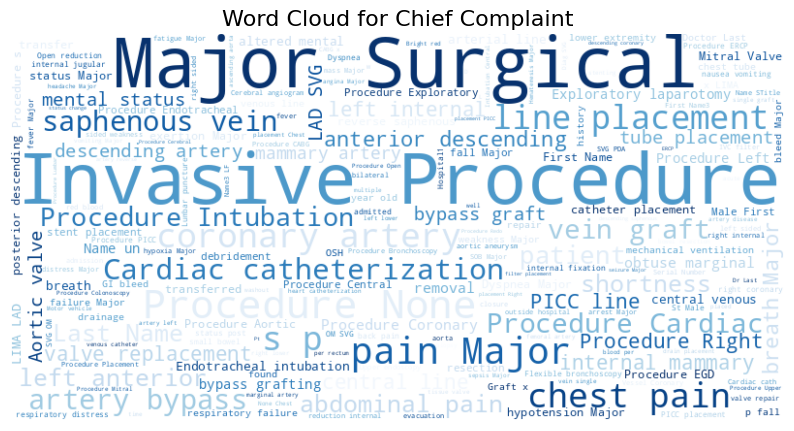

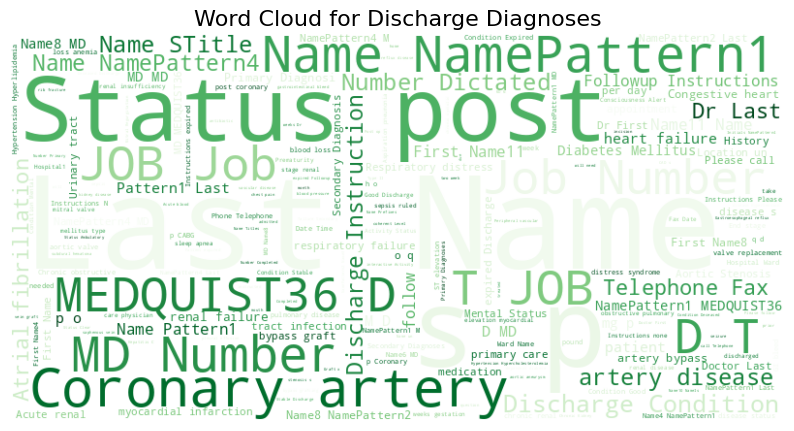

In [ ]:
from wordcloud import WordCloud

# Word cloud for Chief Complaint
text_combined = " ".join(df_data['Chief Complaint'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Chief Complaint', fontsize=16)
plt.axis('off')
plt.show()

# Word cloud for Discharge Diagnoses
text_combined = " ".join(df_data['Discharge Diagnoses'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Discharge Diagnoses', fontsize=16)
plt.axis('off')
plt.show()
